In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install tqdm --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 3.3 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.31.1
    Uninstalling tqdm-4.31.1:
      Successfully uninstalled tqdm-4.31.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
protobuf-compiler 1.0.20 requires tqdm==4.31.1, but you have tqdm 4.64.1 which is incompatible.


In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
base_path = "/content/drive/MyDrive/AI/topics_demo"

datasets_path = base_path + '/datasets/'
model_path = base_path + '/model/'

In [4]:
# datasets_path = "/content/drive/MyDrive/AI/topics_demo/datasets/domain-AI-analysis-1M.zip"

datasets_path = "/content/drive/MyDrive/AI/topics_demo/datasets/top-1m.csv.zip"

In [ ]:
# !apt-get install unzip
!unzip $datasets_path

Source (`domain_ai_analysis_df`): https://www.dizital-mart.com/p/top-1-million-domains/  
Source (`rank_domain_df`): http://s3-us-west-1.amazonaws.com/umbrella-static/index.html 

In [5]:
# column_names = "domain, image_url, title, description, keywords, website_ip, size, country_code, lang, ptile, category, page_lang, harmonicc_pos, pr_pos, n_hosts".split(", ")
# domain_ai_analysis_df = pd.read_csv("/content/domain-AI-analysis-1M.csv", sep=",", lineterminator='\n', header=None, on_bad_lines='skip')
# domain_ai_analysis_df.columns = column_names

rank_domain_df = pd.read_csv("/content/top-1m.csv", sep=",", header=None)
rank_domain_df.columns = ['rank', 'domain']

rank_domain_df

,rank,domain
0,1,google.com
1,2,www.google.com
2,3,microsoft.com
3,4,data.microsoft.com
4,5,netflix.com
...,...,...
999995,999996,acuityeyecaregroup.com
999996,999997,acuracertified.com
999997,999998,ad.dyntracker.de
999998,999999,ad.mediaprimaplus.com.my.cdn.cloudflare.net


# Topics API: Model Execution Demo

This colab makes it easy to load the [TensorFlow Lite](https://www.tensorflow.org/lite) model used by Chrome to infer topics from hostnames.

Before running the steps below, upload the `.tflite` model file and the [override list](https://developer.chrome.com/docs/privacy-sandbox/topics/#where-can-i-find-the-current-classifier-model):

1. Upload the `.tflite` file: locate the file on your computer, then click the folder icon at the left of this page, then click the upload icon.

2. Upload the override list. This is in the same directory as the model file: the filename is `override_list.pb.gz`.

[Access the tflite classifier model file](https://developer.chrome.com/docs/privacy-sandbox/topics/#access-tflite-file) provides more detailed instructions.



## Copy model and override_list to current temp storage

In [ ]:
!cp "/content/drive/MyDrive/AI/topics_demo/model/override_list.pb.gz" .
!cp "/content/drive/MyDrive/AI/topics_demo/model/model.tflite" .

# Libraries, Override List and Taxonomy

In [6]:
!pip install tflite-support-nightly protobuf-compiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tqdm-4.31.1-py2.py3-none-any.whl (48 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.4.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.31.1 which is incompatible.
prophet 1.1.1 requires tqdm>=4.36.1, but you have tqdm 4.31.1 which is incompatible.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.31.1 which is incompatible.


## Override List Loading/Proto Definition

This is copied from chromium source: https://source.chromium.org/chromium/chromium/src/+/main:components/optimization_guide/proto/page_topics_override_list.proto;l=1?q=page_topics_override_list.proto&ss=chromium


In [7]:

proto_path = 'page_topics_override_list.proto'

example_proto = b"""
syntax = "proto2";

// The whole override list.
message PageTopicsOverrideList {
  repeated PageTopicsOverrideEntry entries = 1;
}

// An individual entry in the override list. |domain| is expected to be the
// exact string input that is otherwise passed to the TFLite model, with all
// needed pre-processing and/or cleaning done to it already.
message PageTopicsOverrideEntry {
  optional string domain = 1;
  optional AnnotatedPageTopics topics = 2;
}

// The topic identifiers for the given domain.
message AnnotatedPageTopics {
  repeated int32 topic_ids = 1;
}
"""

with open(proto_path, 'wb') as f:
  f.write(example_proto)

!cd /tmp/
!protoc "page_topics_override_list.proto" --python_out=.
!rm "override_list.pb"
!gzip -dk "override_list.pb.gz"

In [8]:
import page_topics_override_list_pb2

# Read the existing address book.
override_list = page_topics_override_list_pb2.PageTopicsOverrideList()
try:
  f = open("override_list.pb", "rb")
  override_list.ParseFromString(f.read())
  f.close()
except IOError:
  print("Could not open file.")

# Replaces a set of common domain characters with white space. See https://source.chromium.org/chromium/chromium/src/+/main:components/optimization_guide/core/page_topics_model_executor.cc;l=211?q=meaningless%20f:optimization_guide&ss=chromium
def process_domain(domain):
  replace_chars = ['-', '_', '.', '+']
  for rc in replace_chars:
    domain = domain.replace(rc, " ")
  return domain

def check_override_list(override_list, domain):
  if override_list is None:
    return None
  for entry in override_list.entries:
    if entry.domain == domain:
      return entry.topics.topic_ids
  return None


## Taxonomy

In [9]:
# Taxonomy ids and names pulled from here: https://github.com/patcg-individual-drafts/topics/blob/main/taxonomy_v1.md

cat_map = {
1: '/Arts & Entertainment',
2: '/Arts & Entertainment/Acting & Theater',
3: '/Arts & Entertainment/Comics',
4: '/Arts & Entertainment/Concerts & Music Festivals',
5: '/Arts & Entertainment/Dance',
6: '/Arts & Entertainment/Entertainment Industry',
7: '/Arts & Entertainment/Humor',
8: '/Arts & Entertainment/Humor/Live Comedy',
9: '/Arts & Entertainment/Live Sporting Events',
10: '/Arts & Entertainment/Magic',
11: '/Arts & Entertainment/Movie Listings & Theater Showtimes',
12: '/Arts & Entertainment/Movies',
13: '/Arts & Entertainment/Movies/Action & Adventure Films',
14: '/Arts & Entertainment/Movies/Animated Films',
15: '/Arts & Entertainment/Movies/Comedy Films',
16: '/Arts & Entertainment/Movies/Cult & Indie Films',
17: '/Arts & Entertainment/Movies/Documentary Films',
18: '/Arts & Entertainment/Movies/Drama Films',
19: '/Arts & Entertainment/Movies/Family Films',
20: '/Arts & Entertainment/Movies/Horror Films',
21: '/Arts & Entertainment/Movies/Romance Films',
22: '/Arts & Entertainment/Movies/Thriller, Crime & Mystery Films',
23: '/Arts & Entertainment/Music & Audio',
24: '/Arts & Entertainment/Music & Audio/Blues',
25: '/Arts & Entertainment/Music & Audio/Classical Music',
26: '/Arts & Entertainment/Music & Audio/Country Music',
27: '/Arts & Entertainment/Music & Audio/Dance & Electronic Music',
28: '/Arts & Entertainment/Music & Audio/Folk & Traditional Music',
29: '/Arts & Entertainment/Music & Audio/Jazz',
30: '/Arts & Entertainment/Music & Audio/Musical Instruments',
31: '/Arts & Entertainment/Music & Audio/Pop Music',
32: '/Arts & Entertainment/Music & Audio/Rap & Hip-Hop',
33: '/Arts & Entertainment/Music & Audio/Rock Music',
34: '/Arts & Entertainment/Music & Audio/Rock Music/Classic Rock & Oldies',
35: '/Arts & Entertainment/Music & Audio/Rock Music/Hard Rock & Progressive',
36: '/Arts & Entertainment/Music & Audio/Rock Music/Indie & Alternative Music',
37: '/Arts & Entertainment/Music & Audio/Soul & R&B',
38: '/Arts & Entertainment/Music & Audio/Soundtracks',
39: '/Arts & Entertainment/Music & Audio/Talk Radio',
40: '/Arts & Entertainment/Music & Audio/World Music',
41: '/Arts & Entertainment/Music & Audio/World Music/Reggae & Caribbean Music',
42: '/Arts & Entertainment/Online Image Galleries',
43: '/Arts & Entertainment/Online Video',
44: '/Arts & Entertainment/Opera',
45: '/Arts & Entertainment/TV Shows & Programs',
46: '/Arts & Entertainment/TV Shows & Programs/TV Comedies',
47: '/Arts & Entertainment/TV Shows & Programs/TV Documentary & Nonfiction',
48: '/Arts & Entertainment/TV Shows & Programs/TV Dramas',
49: '/Arts & Entertainment/TV Shows & Programs/TV Dramas/TV Soap Operas',
50: '/Arts & Entertainment/TV Shows & Programs/TV Family-Oriented Shows',
51: '/Arts & Entertainment/TV Shows & Programs/TV Reality Shows',
52: '/Arts & Entertainment/TV Shows & Programs/TV Sci-Fi & Fantasy Shows',
53: '/Arts & Entertainment/Visual Art & Design',
54: '/Arts & Entertainment/Visual Art & Design/Design',
55: '/Arts & Entertainment/Visual Art & Design/Painting',
56: '/Arts & Entertainment/Visual Art & Design/Photographic & Digital Arts',
57: '/Autos & Vehicles',
58: '/Autos & Vehicles/Cargo Trucks & Trailers',
59: '/Autos & Vehicles/Classic Vehicles',
60: '/Autos & Vehicles/Custom & Performance Vehicles',
61: '/Autos & Vehicles/Gas Prices & Vehicle Fueling',
62: '/Autos & Vehicles/Motor Vehicles (By Type)',
63: '/Autos & Vehicles/Motor Vehicles (By Type)/Autonomous Vehicles',
64: '/Autos & Vehicles/Motor Vehicles (By Type)/Convertibles',
65: '/Autos & Vehicles/Motor Vehicles (By Type)/Coupes',
66: '/Autos & Vehicles/Motor Vehicles (By Type)/Hatchbacks',
67: '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles',
68: '/Autos & Vehicles/Motor Vehicles (By Type)/Luxury Vehicles',
69: '/Autos & Vehicles/Motor Vehicles (By Type)/Microcars & Subcompacts',
70: '/Autos & Vehicles/Motor Vehicles (By Type)/Motorcycles',
71: '/Autos & Vehicles/Motor Vehicles (By Type)/Off-Road Vehicles',
72: '/Autos & Vehicles/Motor Vehicles (By Type)/Pickup Trucks',
73: '/Autos & Vehicles/Motor Vehicles (By Type)/Scooters & Mopeds',
74: '/Autos & Vehicles/Motor Vehicles (By Type)/Sedans',
75: '/Autos & Vehicles/Motor Vehicles (By Type)/Station Wagons',
76: '/Autos & Vehicles/Motor Vehicles (By Type)/SUVs & Crossovers',
77: '/Autos & Vehicles/Motor Vehicles (By Type)/SUVs & Crossovers/Crossovers',
78: '/Autos & Vehicles/Motor Vehicles (By Type)/Vans & Minivans',
79: '/Autos & Vehicles/Towing & Roadside Assistance',
80: '/Autos & Vehicles/Vehicle & Traffic Safety',
81: '/Autos & Vehicles/Vehicle Parts & Accessories',
82: '/Autos & Vehicles/Vehicle Repair & Maintenance',
83: '/Autos & Vehicles/Vehicle Shopping',
84: '/Autos & Vehicles/Vehicle Shopping/Used Vehicles',
85: '/Autos & Vehicles/Vehicle Shows',
86: '/Beauty & Fitness',
87: '/Beauty & Fitness/Body Art',
88: '/Beauty & Fitness/Face & Body Care',
89: '/Beauty & Fitness/Face & Body Care/Antiperspirants, Deodorants & Body Sprays',
90: '/Beauty & Fitness/Face & Body Care/Bath & Body Products',
91: '/Beauty & Fitness/Face & Body Care/Clean Beauty',
92: '/Beauty & Fitness/Face & Body Care/Make-Up & Cosmetics',
93: '/Beauty & Fitness/Face & Body Care/Nail Care Products',
94: '/Beauty & Fitness/Face & Body Care/Perfumes & Fragrances',
95: '/Beauty & Fitness/Face & Body Care/Razors & Shavers',
96: '/Beauty & Fitness/Fashion & Style',
97: '/Beauty & Fitness/Fitness',
98: '/Beauty & Fitness/Fitness/Bodybuilding',
99: '/Beauty & Fitness/Hair Care',
100: '/Books & Literature',
101: '/Books & Literature/Childrens Literature',
102: '/Books & Literature/Poetry',
103: '/Business & Industrial',
104: '/Business & Industrial/Advertising & Marketing',
105: '/Business & Industrial/Advertising & Marketing/Sales',
106: '/Business & Industrial/Agriculture & Forestry',
107: '/Business & Industrial/Agriculture & Forestry/Food Production',
108: '/Business & Industrial/Automotive Industry',
109: '/Business & Industrial/Aviation Industry',
110: '/Business & Industrial/Business Operations',
111: '/Business & Industrial/Business Operations/Flexible Work Arrangements',
112: '/Business & Industrial/Business Operations/Human Resources',
113: '/Business & Industrial/Commercial Lending',
114: '/Business & Industrial/Construction & Maintenance',
115: '/Business & Industrial/Construction & Maintenance/Civil Engineering',
116: '/Business & Industrial/Defense Industry',
117: '/Business & Industrial/Energy & Utilities',
118: '/Business & Industrial/Energy & Utilities/Water Supply & Treatment',
119: '/Business & Industrial/Hospitality Industry',
120: '/Business & Industrial/Manufacturing',
121: '/Business & Industrial/Metals & Mining',
122: '/Business & Industrial/Pharmaceuticals & Biotech',
123: '/Business & Industrial/Printing & Publishing',
124: '/Business & Industrial/Retail Trade',
125: '/Business & Industrial/Venture Capital',
126: '/Computers & Electronics',
127: '/Computers & Electronics/Antivirus & Malware',
128: '/Computers & Electronics/Computer Peripherals',
129: '/Computers & Electronics/Consumer Electronics',
130: '/Computers & Electronics/Consumer Electronics/Cameras & Camcorders',
131: '/Computers & Electronics/Consumer Electronics/Home Automation',
132: '/Computers & Electronics/Consumer Electronics/Home Theater Systems',
133: '/Computers & Electronics/Consumer Electronics/Wearable Technology',
134: '/Computers & Electronics/Desktop Computers',
135: '/Computers & Electronics/Laptops & Notebooks',
136: '/Computers & Electronics/Network Security',
137: '/Computers & Electronics/Networking',
138: '/Computers & Electronics/Networking/Distributed & Cloud Computing',
139: '/Computers & Electronics/Programming',
140: '/Computers & Electronics/Software',
141: '/Computers & Electronics/Software/Audio & Music Software',
142: '/Computers & Electronics/Software/Desktop Publishing',
143: '/Computers & Electronics/Software/Freeware & Shareware',
144: '/Computers & Electronics/Software/Graphics & Animation Software',
145: '/Computers & Electronics/Software/Operating Systems',
146: '/Computers & Electronics/Software/Photo Software',
147: '/Computers & Electronics/Software/Video Software',
148: '/Computers & Electronics/Software/Web Browsers',
149: '/Finance',
150: '/Finance/Accounting & Auditing',
151: '/Finance/Accounting & Auditing/Tax Preparation & Planning',
152: '/Finance/Credit Cards',
153: '/Finance/Financial Planning & Management',
154: '/Finance/Financial Planning & Management/Retirement & Pension',
155: '/Finance/Grants, Scholarships & Financial Aid',
156: '/Finance/Grants, Scholarships & Financial Aid/Study Grants & Scholarships',
157: '/Finance/Home Financing',
158: '/Finance/Insurance',
159: '/Finance/Insurance/Auto Insurance',
160: '/Finance/Insurance/Health Insurance',
161: '/Finance/Insurance/Home Insurance',
162: '/Finance/Insurance/Life Insurance',
163: '/Finance/Insurance/Travel Insurance',
164: '/Finance/Investing',
165: '/Finance/Investing/Commodities & Futures Trading',
166: '/Finance/Investing/Currencies & Foreign Exchange',
167: '/Finance/Investing/Hedge Funds',
168: '/Finance/Investing/Mutual Funds',
169: '/Finance/Investing/Stocks & Bonds',
170: '/Finance/Personal Loans',
171: '/Finance/Student Loans & College Financing',
172: '/Food & Drink',
173: '/Food & Drink/Cooking & Recipes',
174: '/Food & Drink/Cooking & Recipes/BBQ & Grilling',
175: '/Food & Drink/Cooking & Recipes/Cuisines',
176: '/Food & Drink/Cooking & Recipes/Cuisines/Vegetarian Cuisine',
177: '/Food & Drink/Cooking & Recipes/Cuisines/Vegetarian Cuisine/Vegan Cuisine',
178: '/Food & Drink/Cooking & Recipes/Healthy Eating',
179: '/Food & Drink/Food & Grocery Retailers',
180: '/Games',
181: '/Games/Billiards',
182: '/Games/Card Games',
183: '/Games/Computer & Video Games',
184: '/Games/Computer & Video Games/Action & Platform Games',
185: '/Games/Computer & Video Games/Adventure Games',
186: '/Games/Computer & Video Games/Casual Games',
187: '/Games/Computer & Video Games/Competitive Video Gaming',
188: '/Games/Computer & Video Games/Massively Multiplayer Games',
189: '/Games/Computer & Video Games/Music & Dance Games',
190: '/Games/Computer & Video Games/Simulation Games',
191: '/Games/Computer & Video Games/Sports Games',
192: '/Games/Computer & Video Games/Strategy Games',
193: '/Games/Drawing & Coloring',
194: '/Games/Roleplaying Games',
195: '/Games/Table Tennis',
196: '/Hobbies & Leisure',
197: '/Hobbies & Leisure/Anniversaries',
198: '/Hobbies & Leisure/Birthdays & Name Days',
199: '/Hobbies & Leisure/Diving & Underwater Activities',
200: '/Hobbies & Leisure/Fiber & Textile Arts',
201: '/Hobbies & Leisure/Outdoors',
202: '/Hobbies & Leisure/Outdoors/Fishing',
203: '/Hobbies & Leisure/Outdoors/Hunting & Shooting',
204: '/Hobbies & Leisure/Paintball',
205: '/Hobbies & Leisure/Radio Control & Modeling',
206: '/Hobbies & Leisure/Weddings',
207: '/Home & Garden',
208: '/Home & Garden/Gardening',
209: '/Home & Garden/Home & Interior Decor',
210: '/Home & Garden/Home Appliances',
211: '/Home & Garden/Home Improvement',
212: '/Home & Garden/Home Safety & Security',
213: '/Home & Garden/Household Supplies',
214: '/Home & Garden/Landscape Design',
215: '/Internet & Telecom',
216: '/Internet & Telecom/Email',
217: '/Internet & Telecom/ISPs',
218: '/Internet & Telecom/Phone Service Providers',
219: '/Internet & Telecom/Search Engines',
220: '/Internet & Telecom/Smart Phones',
221: '/Internet & Telecom/Teleconferencing',
222: '/Internet & Telecom/Text & Instant Messaging',
223: '/Internet & Telecom/Web Apps & Online Tools',
224: '/Internet & Telecom/Web Design & Development',
225: '/Internet & Telecom/Web Hosting',
226: '/Jobs & Education',
227: '/Jobs & Education/Education',
228: '/Jobs & Education/Education/Academic Conferences & Publications',
229: '/Jobs & Education/Education/Colleges & Universities',
230: '/Jobs & Education/Education/Distance Learning',
231: '/Jobs & Education/Education/Early Childhood Education',
232: '/Jobs & Education/Education/Early Childhood Education/Preschool',
233: '/Jobs & Education/Education/Homeschooling',
234: '/Jobs & Education/Education/Standardized & Admissions Tests',
235: '/Jobs & Education/Education/Vocational & Continuing Education',
236: '/Jobs & Education/Jobs',
237: '/Jobs & Education/Jobs/Career Resources & Planning',
238: '/Jobs & Education/Jobs/Job Listings',
239: '/Law & Government',
240: '/Law & Government/Crime & Justice',
241: '/Law & Government/Legal',
242: '/Law & Government/Legal/Legal Services',
243: '/News',
244: '/News/Economy News',
245: '/News/Local News',
246: '/News/Mergers & Acquisitions',
247: '/News/Politics',
248: '/News/Weather',
249: '/News/World News',
250: '/Online Communities',
251: '/Online Communities/Dating & Personals',
252: '/Online Communities/Forum & Chat Providers',
253: '/Online Communities/Social Networks',
254: '/People & Society',
255: '/People & Society/Family & Relationships',
256: '/People & Society/Family & Relationships/Ancestry & Genealogy',
257: '/People & Society/Family & Relationships/Marriage',
258: '/People & Society/Family & Relationships/Parenting',
259: '/People & Society/Family & Relationships/Parenting/Adoption',
260: '/People & Society/Family & Relationships/Parenting/Babies & Toddlers',
261: '/People & Society/Family & Relationships/Parenting/Child Internet Safety',
262: '/People & Society/Science Fiction & Fantasy',
263: '/Pets & Animals',
264: '/Pets & Animals/Pet Food & Pet Care Supplies',
265: '/Pets & Animals/Pets',
266: '/Pets & Animals/Pets/Birds',
267: '/Pets & Animals/Pets/Cats',
268: '/Pets & Animals/Pets/Dogs',
269: '/Pets & Animals/Pets/Fish & Aquaria',
270: '/Pets & Animals/Pets/Reptiles & Amphibians',
271: '/Pets & Animals/Veterinarians',
272: '/Real Estate',
273: '/Real Estate/Lots & Land',
274: '/Real Estate/Timeshares & Vacation Properties',
275: '/Reference',
276: '/Reference/Educational Resources',
277: '/Reference/Foreign Language Study',
278: '/Reference/How-To, DIY & Expert Content',
279: '/Science',
280: '/Science/Augmented & Virtual Reality',
281: '/Science/Biological Sciences',
282: '/Science/Biological Sciences/Genetics',
283: '/Science/Chemistry',
284: '/Science/Ecology & Environment',
285: '/Science/Geology',
286: '/Science/Machine Learning & Artificial Intelligence',
287: '/Science/Physics',
288: '/Science/Robotics',
289: '/Shopping',
290: '/Shopping/Antiques & Collectibles',
291: '/Shopping/Childrens Clothing',
292: '/Shopping/Consumer Resources',
293: '/Shopping/Consumer Resources/Coupons & Discount Offers',
294: '/Shopping/Costumes',
295: '/Shopping/Flowers',
296: '/Shopping/Mens Clothing',
297: '/Shopping/Party & Holiday Supplies',
298: '/Shopping/Womens Clothing',
299: '/Sports',
300: '/Sports/American Football',
301: '/Sports/Australian Football',
302: '/Sports/Auto Racing',
303: '/Sports/Baseball',
304: '/Sports/Basketball',
305: '/Sports/Bowling',
306: '/Sports/Boxing',
307: '/Sports/Cheerleading',
308: '/Sports/College Sports',
309: '/Sports/Cricket',
310: '/Sports/Cycling',
311: '/Sports/Equestrian',
312: '/Sports/Extreme Sports',
313: '/Sports/Extreme Sports/Climbing & Mountaineering',
314: '/Sports/Fantasy Sports',
315: '/Sports/Golf',
316: '/Sports/Gymnastics',
317: '/Sports/Hockey',
318: '/Sports/Ice Skating',
319: '/Sports/Martial Arts',
320: '/Sports/Motorcycle Racing',
321: '/Sports/Olympics',
322: '/Sports/Rugby',
323: '/Sports/Running & Walking',
324: '/Sports/Skiing & Snowboarding',
325: '/Sports/Soccer',
326: '/Sports/Surfing',
327: '/Sports/Swimming',
328: '/Sports/Tennis',
329: '/Sports/Track & Field',
330: '/Sports/Volleyball',
331: '/Sports/Wrestling',
332: '/Travel & Transportation',
333: '/Travel & Transportation/Adventure Travel',
334: '/Travel & Transportation/Air Travel',
335: '/Travel & Transportation/Business Travel',
336: '/Travel & Transportation/Car Rentals',
337: '/Travel & Transportation/Cruises & Charters',
338: '/Travel & Transportation/Family Travel',
339: '/Travel & Transportation/Honeymoons & Romantic Getaways',
340: '/Travel & Transportation/Hotels & Accommodations',
341: '/Travel & Transportation/Long Distance Bus & Rail',
342: '/Travel & Transportation/Low Cost & Last Minute Travel',
343: '/Travel & Transportation/Luggage & Travel Accessories',
344: '/Travel & Transportation/Tourist Destinations',
345: '/Travel & Transportation/Tourist Destinations/Beaches & Islands',
346: '/Travel & Transportation/Tourist Destinations/Regional Parks & Gardens',
347: '/Travel & Transportation/Tourist Destinations/Theme Parks',
348: '/Travel & Transportation/Tourist Destinations/Zoos, Aquariums & Preserves',
349: '/Travel & Transportation/Travel Guides & Travelogues',
-2: 'Unknown'
}

## Model Execution Demo


In [10]:
from tflite_support.task import text
from tflite_support.task import core

# Remember, this will fail if you haven't uploaded model.tflite. 
# See instructions at the top of this file.

options = text.BertNLClassifierOptions(
    base_options=core.BaseOptions(
        file_name='model.tflite'))

tflite_topics = text.BertNLClassifier.create_from_options(options)

def CategorySort(elem):
  return elem.score

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
domains = [
           "github.com",
           "wikipedia.org",
           "wikipedia.com", 
           "catalonia.com",
           "cat-food.com"
]

In [23]:
def get_topics(domain):
  topic_list = []
  do_print = False

  if do_print:
    print("domain: ", domain)
  processed_domain = process_domain(domain)
  topics = check_override_list(override_list, processed_domain)

  max_number_of_topics = 2
  if topics != None:
    for c in topics[:max_number_of_topics]:
      topic_list.append(cat_map[c])
      if do_print:
        print("Category: {} \t".format( cat_map[c]))
  else:
    topics = tflite_topics.classify(processed_domain)
    cats = sorted(topics.classifications[0].categories, key=CategorySort)[-5:][::-1]
    for c in cats[:max_number_of_topics]:
      topic_list.append(cat_map[int(c.category_name)])
      if do_print:
        print("Category: {} \t - Score: {}".format( cat_map[int(c.category_name)],  c.score))
  if do_print:  
    print("\n")

  while len(topic_list) < max_number_of_topics:
    topic_list.append('')

  return topic_list


# small test section here
topic_list = []
for domain in domains:
  topic_list.append(get_topics(domain))

pd.DataFrame(topic_list)

,0,1
0,/Computers & Electronics/Programming,/Computers & Electronics/Software
1,/Reference,
2,/Reference,/Arts & Entertainment
3,/Reference,/Business & Industrial
4,/Food & Drink,/Pets & Animals/Pets/Cats


# Compute Topics for dataset

In [37]:
def get_topics_for_dataset(dataset):

  topics_for_domain_df = dataset.progress_apply(lambda row: get_topics(row['domain']), axis=1, result_type="expand")
  topics_for_domain_df.columns = ['topic_1', 'topic_2']
  dataset = pd.concat([dataset, topics_for_domain_df], axis=1)
  return dataset

# small test section here
test_rank_domain_df_test = rank_domain_df.head()
get_topics_for_dataset(test_rank_domain_df_test)

  0%|          | 0/5 [00:00<?, ?it/s]

,rank,domain,topic_1,topic_2
0,1,google.com,/Internet & Telecom/Search Engines,
1,2,www.google.com,/Internet & Telecom,/Internet & Telecom/Search Engines
2,3,microsoft.com,/Computers & Electronics/Consumer Electronics,/Computers & Electronics/Software
3,4,data.microsoft.com,/Computers & Electronics/Software,/Computers & Electronics
4,5,netflix.com,/Arts & Entertainment/Online Video,


In [88]:
# we only compute for the first 10000 domains (for now)
ai_domain_topics_df = get_topics_for_dataset(rank_domain_df.head(10000))
ai_domain_topics_df

  0%|          | 0/10000 [00:00<?, ?it/s]

,rank,domain,topic_1,topic_2
0,1,google.com,/Internet & Telecom/Search Engines,
1,2,www.google.com,/Internet & Telecom,/Internet & Telecom/Search Engines
2,3,microsoft.com,/Computers & Electronics/Consumer Electronics,/Computers & Electronics/Software
3,4,data.microsoft.com,/Computers & Electronics/Software,/Computers & Electronics
4,5,netflix.com,/Arts & Entertainment/Online Video,
...,...,...,...,...
9995,9996,backstory.ebay.com,/Shopping,/Real Estate
9996,9997,api-glb-aeuw1b.smoot.apple.com,/News,/Arts & Entertainment
9997,9998,img1.hulu.com,/News,/Arts & Entertainment
9998,9999,shop.pe,/Shopping,/Food & Drink/Food & Grocery Retailers


In [89]:
cat_map[200]

'/Hobbies & Leisure/Fiber & Textile Arts'

In [90]:
value_searched = "/Hobbies & Leisure/Fiber & Textile Arts"
key = next(key for key, value in cat_map.items() if value == value_searched)
key

200

In [91]:
modified_cat_map_that_includes_empty_topics = cat_map
modified_cat_map_that_includes_empty_topics[0] = ''

ai_domain_topics_df_keys = ai_domain_topics_df.copy(deep=True)
ai_domain_topics_df_keys['t1_key'] = ai_domain_topics_df_keys.progress_apply(lambda row: next(key for key, value in modified_cat_map_that_includes_empty_topics.items() if value == row['topic_1']), axis=1)
ai_domain_topics_df_keys['t2_key'] = ai_domain_topics_df_keys.progress_apply(lambda row: next(key for key, value in modified_cat_map_that_includes_empty_topics.items() if value == row['topic_2']), axis=1)
ai_domain_topics_df_keys

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,rank,domain,topic_1,topic_2,t1_key,t2_key
0,1,google.com,/Internet & Telecom/Search Engines,,219,0
1,2,www.google.com,/Internet & Telecom,/Internet & Telecom/Search Engines,215,219
2,3,microsoft.com,/Computers & Electronics/Consumer Electronics,/Computers & Electronics/Software,129,140
3,4,data.microsoft.com,/Computers & Electronics/Software,/Computers & Electronics,140,126
4,5,netflix.com,/Arts & Entertainment/Online Video,,43,0
...,...,...,...,...,...,...
9995,9996,backstory.ebay.com,/Shopping,/Real Estate,289,272
9996,9997,api-glb-aeuw1b.smoot.apple.com,/News,/Arts & Entertainment,243,1
9997,9998,img1.hulu.com,/News,/Arts & Entertainment,243,1
9998,9999,shop.pe,/Shopping,/Food & Drink/Food & Grocery Retailers,289,179


In [99]:
ai_domain_topics_df_keys_reverse_rank = ai_domain_topics_df_keys.copy(deep=True)
ai_domain_topics_df_keys_reverse_rank['reverse_rank'] = 1000000
ai_domain_topics_df_keys_reverse_rank['reverse_rank'] = ai_domain_topics_df_keys_reverse_rank['reverse_rank'] - ai_domain_topics_df_keys_reverse_rank['rank']
ai_domain_topics_df_keys_reverse_rank

,rank,domain,topic_1,topic_2,t1_key,t2_key,reverse_rank
0,1,google.com,/Internet & Telecom/Search Engines,,219,0,999999
1,2,www.google.com,/Internet & Telecom,/Internet & Telecom/Search Engines,215,219,999998
2,3,microsoft.com,/Computers & Electronics/Consumer Electronics,/Computers & Electronics/Software,129,140,999997
3,4,data.microsoft.com,/Computers & Electronics/Software,/Computers & Electronics,140,126,999996
4,5,netflix.com,/Arts & Entertainment/Online Video,,43,0,999995
...,...,...,...,...,...,...,...
9995,9996,backstory.ebay.com,/Shopping,/Real Estate,289,272,990004
9996,9997,api-glb-aeuw1b.smoot.apple.com,/News,/Arts & Entertainment,243,1,990003
9997,9998,img1.hulu.com,/News,/Arts & Entertainment,243,1,990002
9998,9999,shop.pe,/Shopping,/Food & Drink/Food & Grocery Retailers,289,179,990001


# Save / Load checkpoint

In [ ]:
csv_out_path = '/content/drive/MyDrive/AI/topics_demo/datasets/ai_domain_topics_df_keys_reverse_rank.csv'
ai_domain_topics_df_keys_reverse_rank.to_csv(csv_out_path, sep=',')


ai_domain_topics_df_keys_reverse_rank = pd.read_csv(csv_out_path, sep=',', index_col=0)
ai_domain_topics_df_keys_reverse_rank

This will give us the approximate size of the heatmap

In [100]:
len(ai_domain_topics_df_keys_reverse_rank.topic_1.unique()), len(ai_domain_topics_df_keys_reverse_rank.topic_2.unique())

(157, 193)

In [102]:
heatmap_df = ai_domain_topics_df_keys_reverse_rank[['t1_key', 't2_key', 'reverse_rank']]

heatmap_df = heatmap_df.pivot_table(index = "t1_key", 
              columns = ["t2_key"] , 
              values = "reverse_rank", 
              aggfunc = "sum",
              fill_value=0
              )

heatmap_df

t2_key,-2,0,1,2,3,4,6,7,12,14,...,325,331,332,334,337,340,341,344,347,349
t1_key,,,,,,,,,,,,,,,,,,,,,
-2,0,0,337210727,0,996430,0,0,0,4963486,0,...,6964772,0,4961935,0,0,998655,0,990418,0,1984018
0,0,3963474,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,81594550,994037,0,1988280,4985179,0,990248,6965030,14943796,0,...,991863,0,0,0,998289,0,998380,0,992574,0
3,0,0,996936,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,3980055,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0,991709,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


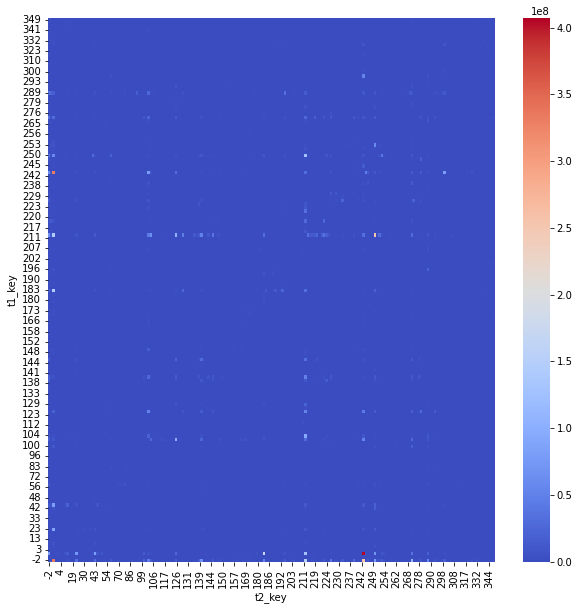

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
# sns.heatmap(heatmap_df, annot=True, linewidths=.5, ax=ax)
sns.heatmap(heatmap_df, ax=ax, cmap="coolwarm")
ax.invert_yaxis()